In [1]:
# load packages
import gc
import pickle
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, uniform
from xgboost import XGBRegressor
from matplotlib import pyplot as plt

## Load the data

In [2]:
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz").set_index("id", drop=True).astype("float16", errors="ignore")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz").set_index("id", drop=True).astype("float16", errors="ignore")
validation_data = tournament_data[tournament_data["data_type"] == "validation"]
del tournament_data
tournament_data = None
gc.collect()

feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

# Loading data...
Loaded 310 features


In [3]:
# prepare data to 2 fold CV
era_list = training_data["era"].unique().tolist()
h1_eras = era_list[:len(era_list)//2]
h2_eras = era_list[len(era_list)//2:]

h1_data = training_data[training_data["era"].isin(h1_eras)]
h2_data = training_data[training_data["era"].isin(h2_eras)]

In [40]:
# get all metrics
def compute_metrics(predictions):
    training_preds_df = pd.DataFrame()
    validation_preds_df = pd.DataFrame()
    
    # create data frame from predictions
    experiments = []
    colsamples = []
    for pred in predictions:
        training_preds_df[pred["name"]] = pred["training_preds"]
        validation_preds_df[pred["name"]] = pred["validation_preds"]
        experiments += [pred["experiment"]]
        colsamples += [pred.get("colsample_bytree")]
    
    # add columns era and target
    training_preds_df["era"] = training_data["era"]
    validation_preds_df["era"] = validation_data["era"]
    training_preds_df["target"] = training_data["target_kazutsugi"]
    validation_preds_df["target"] = validation_data["target_kazutsugi"]
    
    # get scores per era
    model_names = [c for c in validation_preds_df if "era" != c and "target" != c]
    val_scores_per_era = validation_preds_df.groupby("era").apply(lambda d: d[model_names].corrwith(d["target"], method="spearman"))
    training_scores_per_era = training_preds_df.groupby("era").apply(lambda d: d[model_names].corrwith(d["target"], method="spearman"))
    
    # Metrics Data Frame
    metrics_df = pd.DataFrame(index=model_names, columns=[])
    metrics_df["experiment"] = experiments
    metrics_df["colsample_bytree"] = colsamples
    # Calculate mean
    metrics_df["val_mean"] = val_scores_per_era.mean()
    metrics_df["training_mean"] = training_scores_per_era.mean()
    # Calculate sharpe
    metrics_df["val_sharpe"] = val_scores_per_era.mean()/val_scores_per_era.std()
    metrics_df["training_sharpe"] = training_scores_per_era.mean()/training_scores_per_era.std()

    # validation max drawdown
    val_max_drawdown = {}
    for model in model_names:
        rolling_max = (val_scores_per_era[model]+1).cumprod().rolling(window=100, min_periods=1).max()
        daily_value = (val_scores_per_era[model]+1).cumprod()
        val_max_drawdown[model] = (rolling_max - daily_value).max()
    metrics_df["val_max_drawdown"] = pd.Series(val_max_drawdown)

    # training max drawdown
    training_max_drawdown = {}
    for model in model_names:
        rolling_max = (training_scores_per_era[model]+1).cumprod().rolling(window=100, min_periods=1).max()
        daily_value = (training_scores_per_era[model]+1).cumprod()
        training_max_drawdown[model] = (rolling_max - daily_value).max()
    metrics_df["training_max_drawdown"] = pd.Series(training_max_drawdown)
    
    return metrics_df

In [5]:
def compute_predictions(max_depth, learning_rate, n_estimators, colsample_bytree, features, select_eras):
    
    print(f"{name}, max_depth={max_depth}, learning_rate={learning_rate}, n_estimators={n_estimators}, colsample_bytree={colsample_bytree}, eras count={len(select_eras)}, features count={len(features)}")
    
    model = XGBRegressor(max_depth=max_depth,
                         learning_rate=learning_rate,
                         n_estimators=n_estimators,
                         colsample_bytree=colsample_bytree,
                         n_jobs=12,
                         verbosity=1,
                         random_state=12)

    # train on fold 1
    model.fit(h1_data[features][h1_data["era"].isin(select_eras)], h1_data["target_kazutsugi"][h1_data["era"].isin(select_eras)])
    h2_preds = pd.Series(model.predict(h2_data[features]), index=h2_data.index)
    
    # train on fold 2
    model.fit(h2_data[features][h2_data["era"].isin(select_eras)], h2_data["target_kazutsugi"][h2_data["era"].isin(select_eras)])
    h1_preds = pd.Series(model.predict(h1_data[features]), index=h1_data.index)

    # train on all training data
    model.fit(training_data[features][training_data["era"].isin(select_eras)], training_data["target_kazutsugi"][training_data["era"].isin(select_eras)])
    validation_preds = pd.Series(model.predict(validation_data[features]), index=validation_data.index)
    
    return pd.concat([h1_preds, h2_preds]), validation_preds

In [60]:

def compare(metrics_df_org, experiments, colsample_plots = True):
    
    metrics_df = metrics_df_org.copy()
    metrics_df.drop("ExamplePreds", inplace=True)
    
    
    if colsample_plots:
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,15))
    else:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
        
    colors = ["red", "blue", "green"]
    
    for i, expt in enumerate(experiments):
        metrics_df[metrics_df.experiment == expt].plot(x="training_sharpe", y="val_sharpe", 
                                                           kind="scatter", alpha=0.4, 
                                                           label=expt, ax=axes[0,1],
                                                           color=colors[i])
    
    metrics = ["training_mean", "val_sharpe", "val_max_drawdown"]
    axs = [axes[0,0], axes[1,0], axes[1,1]]
    for j, m in enumerate(metrics):
        for i, expt in enumerate(experiments):
            metrics_df[metrics_df.experiment == expt].plot(x=m, y="val_mean", 
                                                           kind="scatter", alpha=0.4, 
                                                           label=expt, ax=axs[j],
                                                           color=colors[i])

    if colsample_plots:
        for i, expt in enumerate(experiments):
            metrics_df[metrics_df.experiment == expt].plot(x="colsample_bytree", y="val_mean", 
                                                           kind="scatter", alpha=0.4, 
                                                           label=expt, ax=axes[2,0],
                                                           color=colors[i])
        for i, expt in enumerate(experiments):
            metrics_df[metrics_df.experiment == expt].plot(x="colsample_bytree", y="val_sharpe", 
                                                           kind="scatter", alpha=0.4, 
                                                           label=expt, ax=axes[2,1],
                                                           color=colors[i])

    metrics = ["training_mean", "val_mean", "training_sharpe", "val_sharpe", "val_max_drawdown"]
    axs = [axes[0,0], axes[1,0], axes[1,1]]
    for f in ["MAX", "MEAN", "MIN"]:
        print("-"*22)
        for j, m in enumerate(metrics):
            for i, expt in enumerate(experiments):
                if f == "MAX":
                    print(m, expt, "MAX", np.max(metrics_df[metrics_df.experiment == expt][m]))
                elif f == "MEAN":
                    print(m, expt, "MEAN", np.mean(metrics_df[metrics_df.experiment == expt][m]))
                else:
                    print(m, expt, "MIN", np.min(metrics_df[metrics_df.experiment == expt][m]))
        

In [7]:
EXPT_SIZE = 20
ESTIMATORS = 50

In [8]:
np.random.seed(1776)

predictions = []
features = feature_names # default, use all features
select_eras = era_list # default, use all eras

for i in range(EXPT_SIZE+1):
    name = f"high_colsample_{i}"
    max_depth = 5
    learning_rate = 0.1
    n_estimators = ESTIMATORS 
    colsample_bytree = 0.7+np.random.rand()*0.3

    experiment_name = "high_colsample"
    if i == 0:
        name = "ExamplePreds"
        max_depth = 5
        learning_rate = 0.01
        n_estimators = 2000
        colsample_bytree = 0.1
        experiment_name = "ExamplePreds"
        

    training_preds, validation_preds = compute_predictions(max_depth, 
                                                           learning_rate, 
                                                           n_estimators, 
                                                           colsample_bytree, 
                                                           features, 
                                                           select_eras)

    predictions += [{
        "name": name,
        "experiment":  experiment_name,
        "training_preds": training_preds,
        "validation_preds": validation_preds,
        "colsample_bytree": colsample_bytree
    }]
    pickle.dump(predictions, open("backup_v3.pickle", "bw"))

ExamplePreds, max_depth=5, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1, eras count=120, features count=310
high_colsample_1, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.8511071462358749, eras count=120, features count=310
high_colsample_2, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.770543128337785, eras count=120, features count=310
high_colsample_3, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.889568614156339, eras count=120, features count=310
high_colsample_4, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.7515124762006702, eras count=120, features count=310
high_colsample_5, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.7049786315275602, eras count=120, features count=310
high_colsample_6, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.7500209202601426, eras count=120, features count=310
high_colsample_7, max_depth=5, learning_rate=

In [9]:
np.random.seed(1776)
for i in range(EXPT_SIZE):
    name = f"low_colsample_{i}"
    max_depth = 5
    learning_rate = 0.1
    n_estimators = ESTIMATORS 
    colsample_bytree = 0.0+np.random.rand()*0.3
    training_preds, validation_preds = compute_predictions(max_depth, 
                                                           learning_rate, 
                                                           n_estimators, 
                                                           colsample_bytree, 
                                                           features, 
                                                           select_eras)

    predictions += [{
        "name": name,
        "experiment": "low_colsample",
        "training_preds": training_preds,
        "validation_preds": validation_preds,
        "colsample_bytree": colsample_bytree
    }]
    pickle.dump(predictions, open("backup_v3.pickle", "bw"))

low_colsample_0, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.04277146852620036, eras count=120, features count=310
low_colsample_1, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.15110714623587498, eras count=120, features count=310
low_colsample_2, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.0705431283377851, eras count=120, features count=310
low_colsample_3, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.1895686141563391, eras count=120, features count=310
low_colsample_4, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.0515124762006702, eras count=120, features count=310
low_colsample_5, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.0049786315275602505, eras count=120, features count=310
low_colsample_6, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.05002092026014264, eras count=120, features count=310
low_colsample_7, max_depth=5

# Eras selection

In [10]:
training_preds_df = pd.DataFrame()
for pred in predictions[:1]: # only ExamplePreds
    training_preds_df[pred["name"]] = pred["training_preds"]
training_preds_df["era"] = training_data["era"]
training_preds_df["target"] = training_data["target_kazutsugi"]
model_names = ["ExamplePreds"]
training_scores_per_era = training_preds_df.groupby("era").apply(lambda d: d[model_names].corrwith(d["target"], method="spearman"))


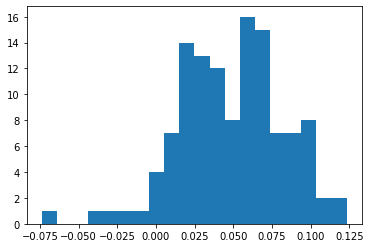

In [11]:
_ = plt.hist(training_scores_per_era["ExamplePreds"], 20)

In [12]:
training_scores_per_era["ExamplePreds"].describe()

count    120.000000
mean       0.048693
std        0.033873
min       -0.073576
25%        0.025353
50%        0.049109
75%        0.070396
max        0.123162
Name: ExamplePreds, dtype: float64

In [13]:
split_at = np.percentile(training_scores_per_era["ExamplePreds"], 50)

In [14]:
easy_eras = training_scores_per_era["ExamplePreds"].index[training_scores_per_era["ExamplePreds"] > split_at].tolist()
hard_eras = training_scores_per_era["ExamplePreds"].index[training_scores_per_era["ExamplePreds"] <= split_at].tolist()

In [15]:
', '.join(easy_eras)

'era1, era10, era105, era108, era109, era11, era115, era118, era12, era120, era13, era14, era15, era16, era2, era20, era22, era23, era24, era26, era28, era30, era36, era37, era38, era4, era43, era44, era45, era47, era48, era5, era51, era55, era56, era6, era61, era63, era64, era7, era71, era72, era75, era76, era77, era78, era79, era8, era83, era86, era88, era90, era92, era93, era94, era95, era96, era97, era98, era99'

In [16]:
', '.join(hard_eras)

'era100, era101, era102, era103, era104, era106, era107, era110, era111, era112, era113, era114, era116, era117, era119, era17, era18, era19, era21, era25, era27, era29, era3, era31, era32, era33, era34, era35, era39, era40, era41, era42, era46, era49, era50, era52, era53, era54, era57, era58, era59, era60, era62, era65, era66, era67, era68, era69, era70, era73, era74, era80, era81, era82, era84, era85, era87, era89, era9, era91'

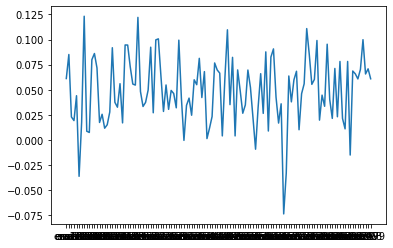

In [17]:
plt.plot(training_scores_per_era["ExamplePreds"])

In [18]:
np.random.seed(1776)
features = feature_names
for i in range(EXPT_SIZE):
    name = f"easy_eras_{i}"
    max_depth = 5
    learning_rate = 0.1
    n_estimators = ESTIMATORS 
    colsample_bytree = 0.3+np.random.rand()*0.4
    training_preds, validation_preds = compute_predictions(max_depth, 
                                                           learning_rate, 
                                                           n_estimators, 
                                                           colsample_bytree, 
                                                           features, 
                                                           easy_eras)

    predictions += [{
        "name": name,
        "experiment": "easy_eras",
        "training_preds": training_preds,
        "validation_preds": validation_preds,
        "colsample_bytree": colsample_bytree
    }]
    pickle.dump(predictions, open("backup_v3.pickle", "bw"))

easy_eras_0, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.35702862470160046, eras count=60, features count=310
easy_eras_1, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5014761949811667, eras count=60, features count=310
easy_eras_2, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3940575044503801, eras count=60, features count=310
easy_eras_3, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5527581522084521, eras count=60, features count=310
easy_eras_4, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3686833016008936, eras count=60, features count=310
easy_eras_5, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3066381753700803, eras count=60, features count=310
easy_eras_6, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3666945603468569, eras count=60, features count=310
easy_eras_7, max_depth=5, learning_rate=0.1, n_estimators=50, colsam

In [19]:
np.random.seed(1776)
features = feature_names
for i in range(EXPT_SIZE):
    name = f"hard_eras_{i}"
    max_depth = 5
    learning_rate = 0.1
    n_estimators = ESTIMATORS 
    colsample_bytree = 0.3+np.random.rand()*0.4
    training_preds, validation_preds = compute_predictions(max_depth, 
                                                           learning_rate, 
                                                           n_estimators, 
                                                           colsample_bytree, 
                                                           features, 
                                                           hard_eras)

    predictions += [{
        "name": name,
        "experiment": "hard_eras",
        "training_preds": training_preds,
        "validation_preds": validation_preds,
        "colsample_bytree": colsample_bytree
    }]
    pickle.dump(predictions, open("backup_v3.pickle", "bw"))

hard_eras_0, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.35702862470160046, eras count=60, features count=310
hard_eras_1, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5014761949811667, eras count=60, features count=310
hard_eras_2, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3940575044503801, eras count=60, features count=310
hard_eras_3, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5527581522084521, eras count=60, features count=310
hard_eras_4, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3686833016008936, eras count=60, features count=310
hard_eras_5, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3066381753700803, eras count=60, features count=310
hard_eras_6, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.3666945603468569, eras count=60, features count=310
hard_eras_7, max_depth=5, learning_rate=0.1, n_estimators=50, colsam

# Neutralize

In [20]:
def neutralize(df, scores, by, proportion=1.0):
    exposures = df[by].values
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()

In [21]:
new_preds = []
for preds in predictions:
    new_preds += [{
        "name": "neutralized_" + preds["name"],
        "experiment": "neutralized_" + preds["experiment"],
        "training_preds": neutralize(training_data, preds["training_preds"], feature_names),
        "validation_preds": neutralize(validation_data, preds["validation_preds"], feature_names),
        "colsample_bytree": preds["colsample_bytree"]
    }]
predictions += new_preds

In [22]:
#pickle.dump(predictions, open("backup_v3.pickle", "bw"))

# Analyze results

In [41]:
metrics_df = compute_metrics(predictions)

In [42]:
metrics_df.head()

,experiment,colsample_bytree,val_mean,training_mean,val_sharpe,training_sharpe,val_max_drawdown,training_max_drawdown
ExamplePreds,ExamplePreds,0.100000,0.029522,0.048693,0.968562,1.437529,0.078947,5.545741
high_colsample_1,high_colsample,0.851107,0.025790,0.041549,0.812189,1.278984,0.071039,3.415843
high_colsample_2,high_colsample,0.770543,0.025353,0.040573,0.793394,1.232532,0.072572,2.895796
high_colsample_3,high_colsample,0.889569,0.025966,0.041021,0.860114,1.221346,0.064457,2.794750
high_colsample_4,high_colsample,0.751512,0.025328,0.041761,0.797031,1.202276,0.086917,3.900581


## `colsample_bytree` low vs high

----------------------
training_mean high_colsample MAX 0.04247875653736934
training_mean low_colsample MAX 0.04374273549826444
val_mean high_colsample MAX 0.027972166323851425
val_mean low_colsample MAX 0.027336417906790166
training_sharpe high_colsample MAX 1.2977492125411518
training_sharpe low_colsample MAX 1.3023105530113255
val_sharpe high_colsample MAX 0.9314164706073689
val_sharpe low_colsample MAX 0.8890930631418525
val_max_drawdown high_colsample MAX 0.08691697481093952
val_max_drawdown low_colsample MAX 0.10901373776362488
----------------------
training_mean high_colsample MEAN 0.041579793167087695
training_mean low_colsample MEAN 0.03753421511229674
val_mean high_colsample MEAN 0.02596817829573487
val_mean low_colsample MEAN 0.022188545542988748
training_sharpe high_colsample MEAN 1.243156176357713
training_sharpe low_colsample MEAN 1.1868366294495514
val_sharpe high_colsample MEAN 0.8536104108761521
val_sharpe low_colsample MEAN 0.7406634697688222
val_max_drawdown high_co

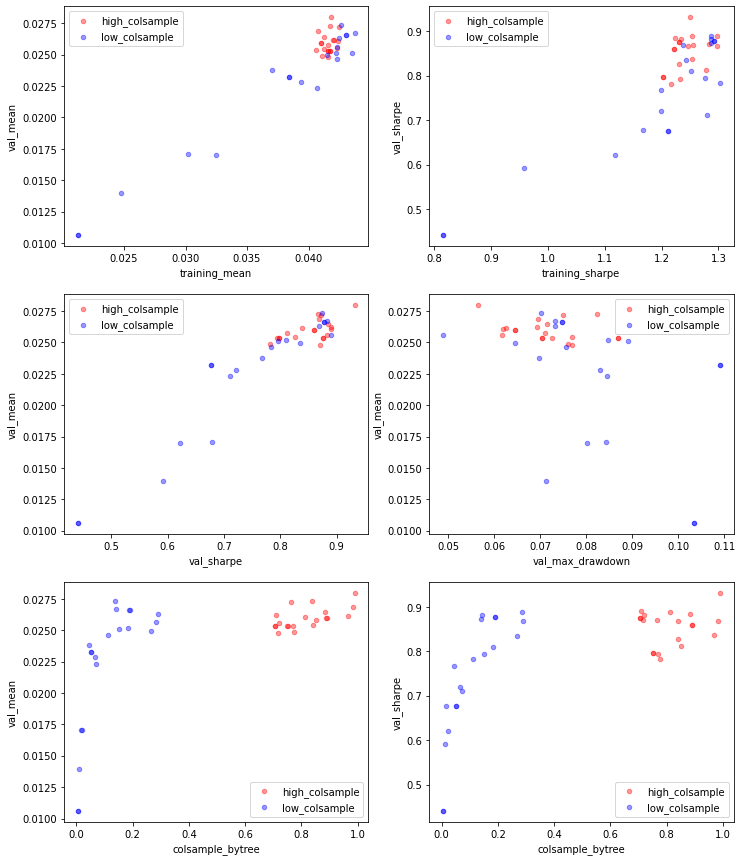

In [61]:
compare(metrics_df, ["high_colsample", "low_colsample"])

## easy vs hard eras

----------------------
training_mean easy_eras MAX 0.04455453364826924
training_mean hard_eras MAX 0.016932630176030975
val_mean easy_eras MAX 0.026465969189361907
val_mean hard_eras MAX 0.015028232293465503
training_sharpe easy_eras MAX 1.1031385327545837
training_sharpe hard_eras MAX 0.7274669091446736
val_sharpe easy_eras MAX 0.6822987665093445
val_sharpe hard_eras MAX 0.793544446504416
val_max_drawdown easy_eras MAX 0.13958833800405746
val_max_drawdown hard_eras MAX 0.11892950683491965
----------------------
training_mean easy_eras MEAN 0.04363257861481375
training_mean hard_eras MEAN 0.014793346088155948
val_mean easy_eras MEAN 0.024463272917917757
val_mean hard_eras MEAN 0.010827332788950298
training_sharpe easy_eras MEAN 1.0610645119776416
training_sharpe hard_eras MEAN 0.6268127965567225
val_sharpe easy_eras MEAN 0.6163919554437711
val_sharpe hard_eras MEAN 0.5519496549443975
val_max_drawdown easy_eras MEAN 0.11932491807044661
val_max_drawdown hard_eras MEAN 0.07267407932399336

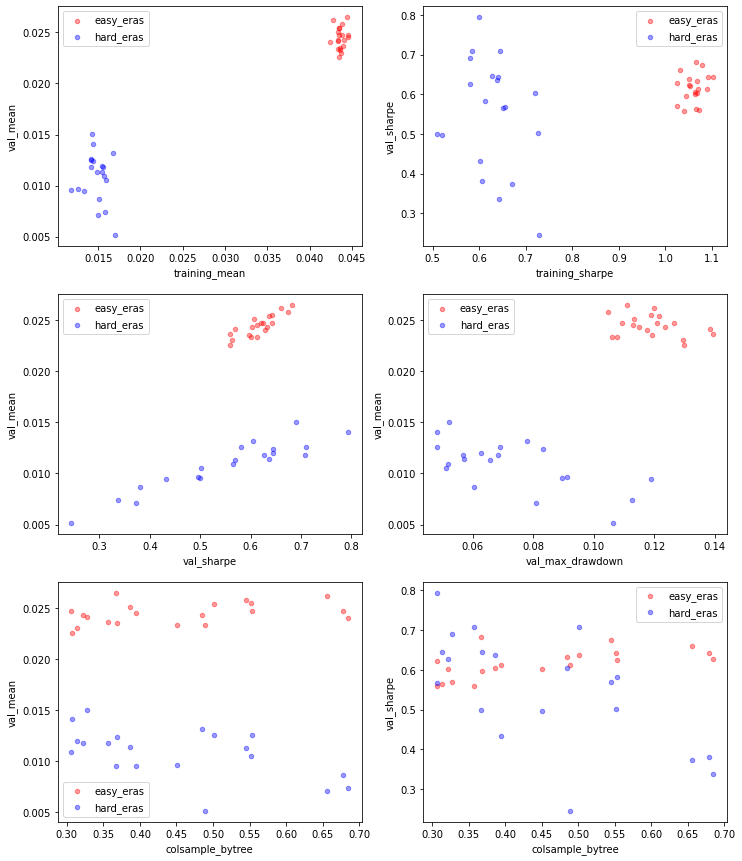

In [62]:
compare(metrics_df, ["easy_eras", "hard_eras"])

## neutralized high colsample 

----------------------
training_mean high_colsample MAX 0.04247875653736934
training_mean neutralized_high_colsample MAX 0.01267862412039768
val_mean high_colsample MAX 0.027972166323851425
val_mean neutralized_high_colsample MAX 0.02268279849914095
training_sharpe high_colsample MAX 1.2977492125411518
training_sharpe neutralized_high_colsample MAX 0.6276165994334757
val_sharpe high_colsample MAX 0.9314164706073689
val_sharpe neutralized_high_colsample MAX 1.067454592046834
val_max_drawdown high_colsample MAX 0.08691697481093952
val_max_drawdown neutralized_high_colsample MAX 0.06617891746570836
----------------------
training_mean high_colsample MEAN 0.041579793167087695
training_mean neutralized_high_colsample MEAN 0.01112359867936002
val_mean high_colsample MEAN 0.02596817829573487
val_mean neutralized_high_colsample MEAN 0.019560598126851864
training_sharpe high_colsample MEAN 1.243156176357713
training_sharpe neutralized_high_colsample MEAN 0.5272275933951578
val_sharpe high_colsa

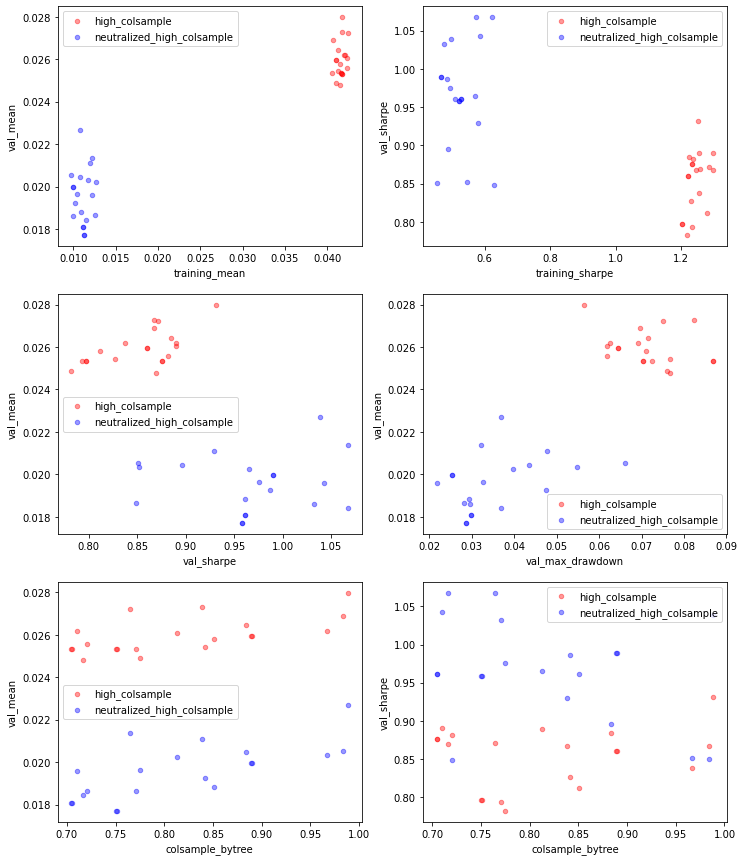

In [63]:
compare(metrics_df, ["high_colsample", "neutralized_high_colsample"])

## neutralized easy eras

----------------------
training_mean easy_eras MAX 0.04455453364826924
training_mean neutralized_easy_eras MAX 0.016918657179867666
val_mean easy_eras MAX 0.026465969189361907
val_mean neutralized_easy_eras MAX 0.01858620149873445
training_sharpe easy_eras MAX 1.1031385327545837
training_sharpe neutralized_easy_eras MAX 0.8533257544885557
val_sharpe easy_eras MAX 0.6822987665093445
val_sharpe neutralized_easy_eras MAX 1.195949372876037
val_max_drawdown easy_eras MAX 0.13958833800405746
val_max_drawdown neutralized_easy_eras MAX 0.04106514399054295
----------------------
training_mean easy_eras MEAN 0.04363257861481375
training_mean neutralized_easy_eras MEAN 0.015210229921274711
val_mean easy_eras MEAN 0.024463272917917757
val_mean neutralized_easy_eras MEAN 0.015250147273694883
training_sharpe easy_eras MEAN 1.0610645119776416
training_sharpe neutralized_easy_eras MEAN 0.7555310870494019
val_sharpe easy_eras MEAN 0.6163919554437711
val_sharpe neutralized_easy_eras MEAN 0.8819791128342

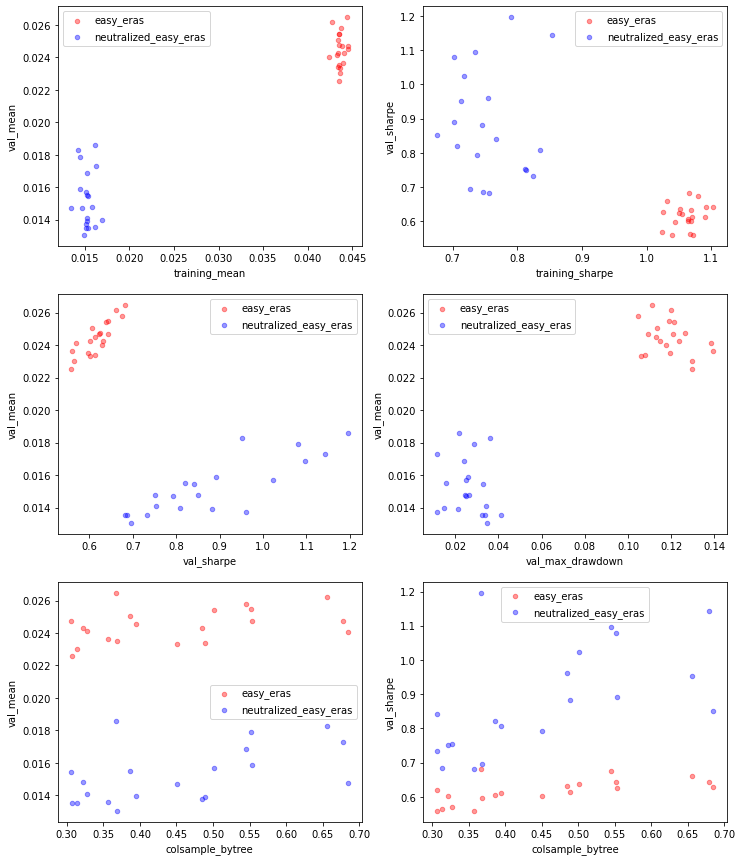

In [64]:
compare(metrics_df, ["easy_eras", "neutralized_easy_eras"])